# Data preprocessing and binary classification

So in this exercise we are working with two datasets. Training dataset, which contains predicted value 'Survived' and the testing dataset which we will use in order to predict who actually Survived during the Titanic catastrophe.

_Our predicted variable (y):_
* survived - 0 = No, 1 = Yes

_A list of features (X):_
* pclass - the first second or third class
* name - name and surname with title
* sex -male or female
* age - in numbers
* sibsp - the number of siblings or spouses on board
* parch - the number of parents or children on board
* ticket - the ticket number
* fare - the price of the ticket
* cabin - cabin number
* embarked - C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - home destination

# 1.  Import libraries & data

As first step in my project, I will import all necessary modules and packages, which I will be use for my data modeling.

In [2]:
# Data handling and processing
import pandas as pd
import numpy as np

# Data visualisation 
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning algorithms
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Model fine-tuning and evaluation
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import GridSearchCV # concerning that it gives a better result then RandomSearchCV and the size of the data i relatively small
from sklearn import model_selection
from sklearn.metrics import confusion_matrix

In [3]:
# reading data to pandas df
train = pd.read_csv('data.csv')
test = pd.read_csv('evaluation.csv')
display(train.head())

,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,1,3,"Nysten, Miss. Anna Sofia",female,22.0,0,0,347081,7.7500,NaN,S,NaN
1,1,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,NaN
2,2,1,1,"Bishop, Mrs. Dickinson H (Helen Walton)",female,19.0,1,0,11967,91.0792,B49,C,"Dowagiac, MI"
3,3,0,3,"Saad, Mr. Khalil",male,25.0,0,0,2672,7.2250,NaN,C,NaN
4,4,0,3,"Fox, Mr. Patrick",male,NaN,0,0,368573,7.7500,NaN,Q,"Ireland New York, NY"


# 2. Basic Data Exploration


In this part, I will check the quality of my data. Being precise, I will explore if there are null (NaN) values presented in the dataset and what column datatypes we are dealing with.

_Missing values:_

There are few approaches how to deal with missing values:
*  missing values can be dropped (.dropna() pandas method)
*  missing values can replaced by median, mean or mode with .fillna() pandas method or SimpleImputer()
*  missing values can replaced with SimpleImputer() and then additional column which shows 'rows' where the value was imputed is added (An Extension To Imputation)
*  missing values can replaced with KNNImputer() provides imputation for filling in missing values using the k-Nearest Neighbors approach
*  missing values can replaced with IterativeImputer() which models each feature with missing values as a function of other features
*  missing values can replaced with MissingIndicator() which marks imputed values 


As it is seen, home destination column and cabin column are missing over 40 % of all values, so for my model thses columns will be dropped. The age column (which is missing 20% of data) will be filled, as well as embarked (0.1%) and fare (0.2%) columns in train dataset.

_Datatypes:_

For many ML algorithms categorical values are not desirable as many ML learning algorithms are working with just numerical values. The basic approaches how to deal with categorical variables will be discussed below.

The dataset has 4 object columns, which are name, sex, ticket and embarked. Before we start modeling, we would need to encode them.

In [4]:
# Let's first look how many values are missing in our trainig and testing data (shown in percentage)
display('The percentage of missing values in train dataset: ')
display(train.isna().sum() / len(train) *100)
display('The percentage of missing values in test dataset: ')
display(round(test.isna().sum() / len(test)* 100), 2)

# Let's now explore the data types of columns
#display(train.dtypes, test.dtypes)

# let's explore how many unique elements in every column
train.nunique()

'The percentage of missing values in train dataset: '

ID            0.0
survived      0.0
pclass        0.0
name          0.0
sex           0.0
age          20.1
sibsp         0.0
parch         0.0
ticket        0.0
fare          0.1
cabin        77.3
embarked      0.2
home.dest    43.5
dtype: float64

'The percentage of missing values in test dataset: '

ID            0.0
pclass        0.0
name          0.0
sex           0.0
age          20.0
sibsp         0.0
parch         0.0
ticket        0.0
fare          0.0
cabin        78.0
embarked      0.0
home.dest    42.0
dtype: float64

2

ID           1000
survived        2
pclass          3
name          998
sex             2
age            95
sibsp           7
parch           8
ticket        748
fare          256
cabin         161
embarked        3
home.dest     319
dtype: int64

In [5]:
# Dropping columns
to_drop=['home.dest', 'cabin']
train = train.drop(to_drop, axis=1)
test = test.drop(to_drop, axis=1)

# 3. Visual Data Exploration

In this part, I will check which columns (features) do really have a major impact on the Survived column. I will first check if there are strong correlation between feature columns. I will exclude from correlation matrix 'ID' column, as it is unique of the row and it does not have any effect on 'survived' column.I will also exclude 'name' as it should not have any impact on 'survived' column.

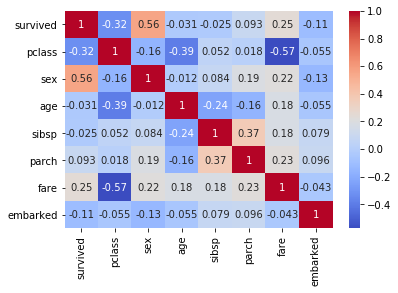

In [6]:
cols = train.columns.tolist()
corr_matrix_df = train.copy()
cols.remove('name')
cols.remove('ID')
# some columns should be mapped as correlation does not work with categorical variables
corr_matrix_df['sex'] = corr_matrix_df['sex'].apply(lambda x: 1 if x == 'female'  else 0)
corr_matrix_df['embarked'] = corr_matrix_df['embarked'].map({'Q': 0, 'C': 1, 'S': 2})
corr_matrix=sns.heatmap(corr_matrix_df[cols].corr(),annot=True, cmap = "coolwarm")

As it is seen from the correlation matrix, the correlation between the correlation and sex is relatively strong, though some other columns show weak corelation to survived. If there are strong correlation between columns (above 0.7 or below -0.7), one of the column is often removed as it doesn't improve the model, do not bring extra information to it. It can improve the speed of the model, decrease dimentionality etc.

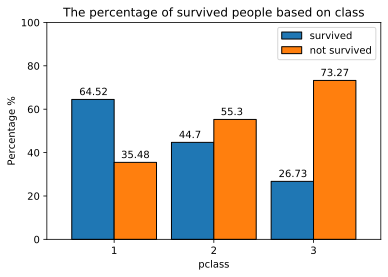

In [7]:
%config InlineBackend.figure_format = 'svg'
# Feature 1 - pclass
pclass_pivot = train.pivot_table(index="pclass",values="survived")*100
not_survived = 100-pclass_pivot
df_merged = pclass_pivot.merge(not_survived, how='outer', left_index=True, right_index=True)
df_merged.columns = ['survived', 'not survived']
df_merged.plot.bar(edgecolor='black', width=0.85)
for i,v in enumerate(df_merged['survived']):
     plt.text(i-0.35, v+2, str(round(v,2)), color='black')
for i,v in enumerate(df_merged['not survived']):
     plt.text(i+0.07, v+2, str(round(v,2)), color='black')
plt.ylim([0, 100])
plt.xticks(rotation='horizontal')
plt.ylabel('Percentage %')
plt.title('The percentage of survived people based on class')
plt.show()

As it is seen from upper figure, there are more passengers survived from the first class compared to the second and third. This would be a valuable feature as the algorithm would be more likely to predict that person survived if the person had the first class ticket (cabin) and that person died if he/she purchased a third class ticket.  

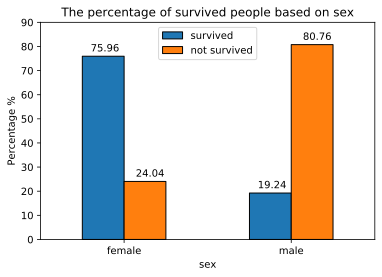

In [8]:
%config InlineBackend.figure_format = 'svg'
# Feature 2 - sex
sex_pivot = train.pivot_table(index="sex",values="survived")*100
not_survived = 100-sex_pivot
df_merged = sex_pivot.merge(not_survived, how='outer', left_index=True, right_index=True)
df_merged.columns = ['survived', 'not survived']
df_merged.plot.bar(edgecolor='black', width=0.5)
for i,v in enumerate(df_merged['survived']):
     plt.text(i-0.2, v+2, str(round(v,2)), color='black')
for i,v in enumerate(df_merged['not survived']):
     plt.text(i+0.07, v+2, str(round(v,2)), color='black')
plt.title('The percentage of survived people based on sex')
plt.ylim([0, 90])
plt.xticks(rotation='horizontal')
plt.ylabel('Percentage %')
plt.show()

As previously, this would be a valuable feature as the algorithm would be more likely to predict for a female that she survived and for a male that he didn't. This also confirms what we saw before in correlation matrix.

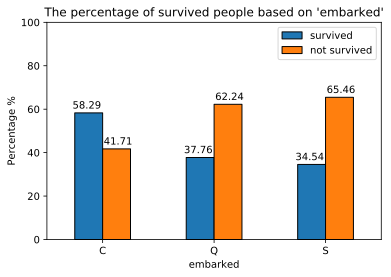

In [9]:
%config InlineBackend.figure_format = 'svg'
# Feature 3 - embarked
embarked_pivot = train.pivot_table(index="embarked",values="survived")*100
not_survived = 100-embarked_pivot
df_merged = embarked_pivot.merge(not_survived, how='outer', left_index=True, right_index=True)
df_merged.columns = ['survived', 'not survived']
df_merged.plot.bar(edgecolor='black', width=0.5)
for i,v in enumerate(df_merged['survived']):
     plt.text(i-0.27, v+2, str(round(v,2)), color='black')
for i,v in enumerate(df_merged['not survived']):
     plt.text(i+0.01, v+2, str(round(v,2)), color='black')
plt.ylim([0, 100])
plt.title("The percentage of survived people based on 'embarked'")
plt.xticks(rotation='horizontal')
plt.ylabel('Percentage %')
plt.show()

Again, for passengers who embarked from Cherburg (C), the chance to survive will be evaluated to be higher than for those who embarked in Queenstown (Q) or Southampton (S). 

c:\users\kate\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\users\kate\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


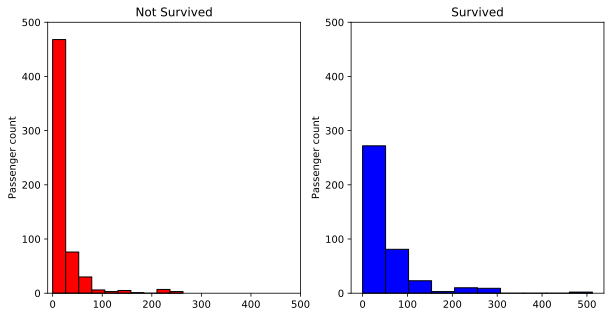

In [10]:
%config InlineBackend.figure_format = 'svg'
# Feature 4 - fare
train_fare = train.copy()
train_fare = train_fare.drop(['ID', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'embarked'], axis=1)
train_fare_survived = train_fare[train_fare.survived == 1]
train_fare_died = train_fare[train_fare.survived == 0]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(train_fare_died['fare'], color='red', edgecolor='black')
axs[0].set_title('Not Survived')
axs[1].hist(train_fare_survived['fare'], color='blue', edgecolor='black')
axs[1].set_title('Survived')
axs[0].set_xlim([-10,500])
axs[0].set_ylim([0,500])
axs[1].set_ylim([0,500])
axs[0].set_ylabel('Passenger count')
axs[1].set_ylabel('Passenger count')
plt.show()

For such ugly distributions like shown above, it is recommended to use log transformation as many machine learning algorithms also tend to assume a normal distribution (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/discussion/60861). Now the distribution looks at least centered and we can compare values. 

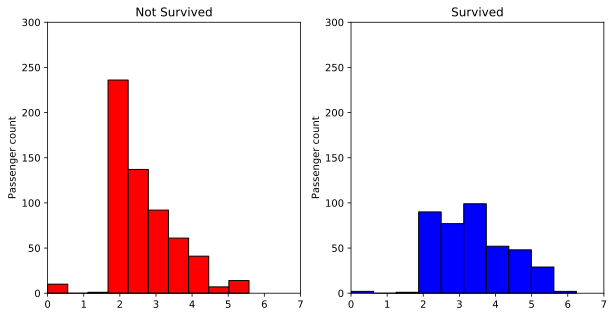

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(train_fare_died['fare'].map(np.log1p), color='red', edgecolor='black')
axs[0].set_title('Not Survived')
axs[1].hist(train_fare_survived['fare'].map(np.log1p), color='blue', edgecolor='black')
axs[1].set_title('Survived')
axs[0].set_xlim([0,7])
axs[1].set_xlim([0,7])
axs[0].set_ylim([0,300])
axs[1].set_ylim([0,300])
axs[0].set_ylabel('Passenger count')
axs[1].set_ylabel('Passenger count')
plt.show()

As it is seen from this plot, the pattern for survived and not survived looks simillar, though more passengers died with the cheaper ticket (fare). So this feature will be also valuable for us.

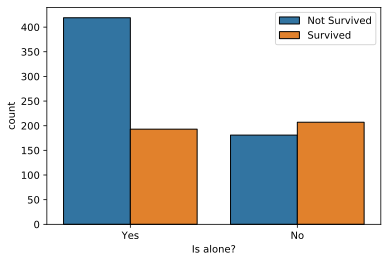

In [12]:
%config InlineBackend.figure_format = 'svg'
# Feature 5 - sibsp, parch
train_relatives = train.copy()
train_relatives['family_members'] = train_relatives['parch'] + train_relatives['sibsp']
train_relatives['is_alone'] = 'Yes'
train_relatives.loc[train_relatives['family_members'] >= 1, 'is_alone'] = 'No'
train_relatives = train_relatives.drop(['ID', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket','fare', 'embarked', 'family_members'], axis=1)
sns.countplot(x='is_alone',hue='survived', data=train_relatives, edgecolor='black')
plt.xlabel('Is alone?')
plt.legend(['Not Survived', 'Survived'])
plt.show()

Regarding the upper plot, there will be more chance that person will not survive if he/she was alone on board. 

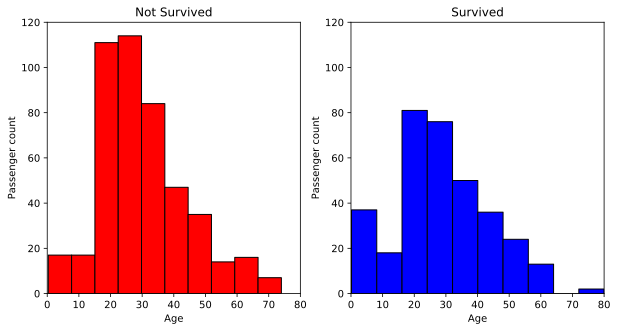

In [13]:
%config InlineBackend.figure_format = 'svg'
# Feature 6 - age
train_relatives = train.copy()
age_survived = train_relatives[train_relatives['survived']==1]
age_not_survived = train_relatives[train_relatives['survived']==0]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(age_not_survived['age'], color='red', edgecolor='black', bins=10)
axs[0].set_title('Not Survived')
axs[1].hist(age_survived['age'], color='blue', edgecolor='black', bins=10)
axs[1].set_title('Survived')
axs[0].set_ylabel('Passenger count')
axs[1].set_ylabel('Passenger count')
axs[0].set_xlabel('Age')
axs[1].set_xlabel('Age')
axs[0].set_xlim([0,80])
axs[1].set_xlim([0,80])
axs[0].set_ylim([0,120])
axs[1].set_ylim([0,120])
plt.show()

As it is seen from the upper plot, relatively more children below age 10 survived in the catastrophe, though relatively more people aged over 60 did not survive during the titanic crash. As it is seen from plot, the age distribution is right-skewed, so it would be better to use median for filling missing age data rather than mean.

# 4. Feature Engineering

As was mentioned previously, we are dealing with 4 categorical variables, which are name, sex, ticket and embarked. In order to use these variables for a machine learning model, we would need to encode them. For 'sex' column we have only two possible values (Female and Male), for 'embarked' column - three possible values (C, S and Q), the same pattern is for 'pclass' column. But what we should do with 'name' column? Looking at this column, we can try extract titles and categorize them into groups, which could tell us about social status of passengers. The other topic for discussion is 'fare' column. I would also need to create categories for a ticket to not feed the model with a huge number of different values. Do I need a 'ticket' column for the model? So far I think I dont need this column or I can extract the number from this 'object' column. Would this information valuable? If there is a pattern like for example the first number represents the floor number, it maybe valuable. Maybe passengers in third floor had easier access for leaving the ship. So far, i don't know and I decided to drop it. I decided to sum up columns 'sibsp' and 'parch' to detect if the person was alone or not on board during the catastrophe.

_There are three main approaches how to deal with categorical variables (https://www.kaggle.com/alexisbcook/categorical-variables):_
* Dropping categorical variables (does not seems to be high effective but it depends on the feature) 
* Label Encoding (mapping) - for ordinal values
* One-Hot Encoding (creating dummies variables) - for non-ordinal values

Summary:
* There is no order for 'sex', 'embarked', 'pclass', 'title', 'age' columns. -> One-Hot Encoder 
* There is an order for 'age', 'fare', 'family_members', columns -> Label Encoder

As a first step I need to separate survived column from all other columns which will be used as features.

In [14]:
# separate target from predictors
X = train.copy()
y = X.survived
X = X.drop('survived', axis=1)

As I meantioned previouly, I still have missing values for age embarked and fare columns. In this section, I will extrapolate them and realize my idea to create a title. 

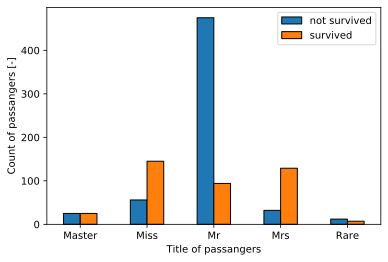

In [15]:
# Feature 1: Embarked
X['embarked'] = X['embarked'].fillna('C') # I will pick up the most frequent one

#Feature 2: Age
X['age'] = X['age'].fillna(X['age'].median()) # as age distribution is right-skewed
X['age'] = X['age'].astype(int)

#Feature 3: Fare
X['fare'] = X['fare'].map(np.log1p)
X['fare'] = X['fare'].fillna(X['fare'].median())
X['fare'] = X['fare'].astype(int)

# Feature 4: Title
import re
def get_title(persons_name):
    title_search = re.search('([A-Za-z]+)\.', persons_name)
    if title_search:
        return title_search.group(1)
    return ""

X['title'] = X['name'].apply(get_title)
X['title'] = X['title'].replace(['Lady', 'Capt', 'Col','Don', 'Dr', 'Rev','Countess', 'Sir', 'Jonkheer',  'Major', 'Dona'],'Rare')
X['title'] = X['title'].replace('Mlle','Miss')
X['title'] = X['title'].replace('Mme','Mrs')
X['title'] = X['title'].replace('Ms','Miss')

#graphical representation of Title
df = pd.DataFrame({'title':X['title'], 'survived': y, 'ID': X['ID']})
pivot_df = pd.pivot_table(df, index='title', columns='survived', aggfunc='count')
pivot_df.plot.bar(edgecolor='black')
plt.legend(['not survived', 'survived'])
plt.ylabel('Count of passangers [-]')
plt.xlabel('Title of passangers')
plt.xticks(rotation='horizontal')

# Feature 5: Family members
X['family_members'] = X['sibsp'] + X['parch']

As we can see from the plot, that passsengers with 'Mr' title would be more likely to be predicted 'not survived'.

In [16]:
# Cleaning after creation of new columns
cols_to_drop = ['ID', 'name', 'sibsp', 'parch', 'ticket']
X = X.drop(cols_to_drop, axis=1)

In [17]:
# Encoding columns
# Make copy to avoid changing original data 
X_mapped = X.copy()
X_mapped.info()
# Columns to encode
OH_encoder_cols = ['sex', 'embarked', 'pclass', 'title']
LA_ecoder_cols = ['age', 'fare', 'family_members']

# map the age into 4 equal categories
X_mapped['age'] = pd.qcut(X_mapped['age'], 4)

def encode_categories(df, LA_cols, OH_cols):
    le = LabelEncoder()
    for col in LA_cols:
        df[col] = le.fit_transform(df[col])
    for col in OH_cols:
        prefix = 'd_' + col
        df = pd.concat([df.drop(columns=[col]), pd.get_dummies(df[col], prefix=prefix)], axis=1)
    return df

encoded_train = encode_categories(X_mapped, LA_ecoder_cols, OH_encoder_cols)
display(encoded_train.head())
#print(encoded_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
pclass            1000 non-null int64
sex               1000 non-null object
age               1000 non-null int32
fare              1000 non-null int32
embarked          1000 non-null object
title             1000 non-null object
family_members    1000 non-null int64
dtypes: int32(2), int64(2), object(3)
memory usage: 47.0+ KB


,age,fare,family_members,d_sex_female,d_sex_male,d_embarked_C,d_embarked_Q,d_embarked_S,d_pclass_1,d_pclass_2,d_pclass_3,d_title_Master,d_title_Miss,d_title_Mr,d_title_Mrs,d_title_Rare
0,0,2,0,1,0,0,0,1,0,0,1,0,1,0,0,0
1,1,2,0,0,1,0,1,0,0,0,1,0,0,1,0,0
2,0,4,1,1,0,1,0,0,1,0,0,0,0,0,1,0
3,1,2,0,0,1,1,0,0,0,0,1,0,0,1,0,0
4,1,2,0,0,1,0,1,0,0,0,1,0,0,1,0,0


Now I will apply PCA for feature seletion. PCA is used to reduce the dimentionality of the data as it can improves the interpretation of the parameters of the machine learning model. With PCA we can pick up columns based on the explained variance ratio. Even though, the variance explained ration was quite low for the last four title columns I decided not to drop these columns.

Index(['age', 'fare', 'family_members', 'd_sex_female', 'd_sex_male',
       'd_embarked_C', 'd_embarked_Q', 'd_embarked_S', 'd_pclass_1',
       'd_pclass_2', 'd_pclass_3', 'd_title_Master', 'd_title_Miss',
       'd_title_Mr', 'd_title_Mrs', 'd_title_Rare'],
      dtype='object')
[3.74255786e-01 2.31736180e-01 1.30927761e-01 9.58762246e-02
 5.73019769e-02 3.71922517e-02 2.67211767e-02 1.73953907e-02
 1.41775004e-02 1.06896476e-02 3.41080166e-03 3.15301622e-04
 4.19766264e-32 1.10839775e-32 7.01753959e-33 5.19328022e-33]


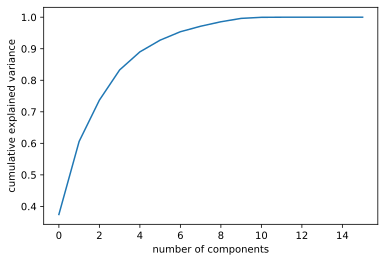

In [18]:
# Create the scaler and standardize the data
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
ansur_std = scaler.fit_transform(encoded_train)

# Set up PCA and the X vector for dimensionality reduction
pca = PCA()
print(encoded_train.columns)
# Apply PCA to the wine dataset X vector
transformed_X = pca.fit_transform(encoded_train)

# Look at the percentage of variance explained by the different components
print(pca.explained_variance_ratio_)

# Choosing the number of komponents
var = pca.explained_variance_ratio_.cumsum()
plt.plot(var)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

From the graph we can see that we need just 3 components in order to explain 99.5 percent of variance. So that would mean that I need just 8 component to explain all variance in data. I think I increased the number of columns just because I needed to encode some columns with dummies. So I wont change anything in my dataset and I will start with data modeling.

# 5. Data Modeling

In order to try different models on our data I will create functions, which will be called after for different ML algorithms. The first function will be called to check the accuracy score of some classification algorithms. The second function will be called to tune hyperparameters for some models to extract the best score.

In [19]:
def create_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=333)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Confusion matrix
    predictions = cross_val_predict(model, X_train, y_train, cv=3)
    print(
        'accuracy score (test): ', model.score(X_test, y_test), '\n',
        'accuracy score (train): ',  model.score(X_train, y_train), '\n',
        'Confusion matrix: \n', confusion_matrix(y_train, predictions))

In [20]:
def create_model_with_grid(model, params, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=333)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=333)
    # Instantiate a 10-fold CV grid search object grid
    grid = GridSearchCV(estimator=model,
                        param_grid=params,
                        scoring='accuracy',
                        cv=10,
                        n_jobs=-1)
    # Fit grid to the training data
    grid.fit(X_train, y_train)
    # Extract best model from grid
    best_model = grid.best_estimator_
    # Confusion matrix
    predictions = cross_val_predict(best_model, X_train, y_train, cv=3)
    print(
          'Best hyperparameters:\n', grid.best_params_, '\n',
          'accuracy score (test): ', best_model.score(X_test, y_test), '\n',
          'accuracy score (train): ', best_model.score(X_train, y_train), '\n',
          'accuracy score (validation): ', best_model.score(X_val, y_val), '\n',
          'Confusion matrix: \n', confusion_matrix(y_train, predictions))

Applying some classification algorithms on our data.

In [21]:
models = {'Decision Tree': DecisionTreeClassifier(),
          'Random Forest' : RandomForestClassifier(),
          'Logistic Regression': LogisticRegression( max_iter=1000),
          'Adabooost' : AdaBoostClassifier(),
          'kNN': KNeighborsClassifier(),
          'NB Gaussian' : GaussianNB(),
          'NB Bernouli' : BernoulliNB()}

for key, value in models.items():
    print('Model: ', key)
    create_model(value, encoded_train, y)

Model:  Decision Tree
accuracy score (test):  0.795 
 accuracy score (train):  0.875 
 Confusion matrix: 
 [[407  61]
 [128 204]]
Model:  Random Forest
accuracy score (test):  0.82 
 accuracy score (train):  0.875 
 Confusion matrix: 
 [[405  63]
 [114 218]]
Model:  Logistic Regression
accuracy score (test):  0.825 
 accuracy score (train):  0.81125 
 Confusion matrix: 
 [[396  72]
 [ 85 247]]
Model:  Adabooost
accuracy score (test):  0.835 
 accuracy score (train):  0.80875 
 Confusion matrix: 
 [[372  96]
 [ 80 252]]
Model:  kNN
accuracy score (test):  0.82 
 accuracy score (train):  0.84125 
 Confusion matrix: 
 [[397  71]
 [107 225]]
Model:  NB Gaussian
accuracy score (test):  0.775 
 accuracy score (train):  0.8025 
 Confusion matrix: 
 [[382  86]
 [ 87 245]]
Model:  NB Bernouli
accuracy score (test):  0.81 
 accuracy score (train):  0.7875 
 Confusion matrix: 
 [[400  68]
 [100 232]]


Here we can compare different classification algorithms. The highest accuracy score (test) observed for Random Forestand, Logistic Regression and Adaboost. We can try tuning different hyperparameters in order further improve their score. However, I will try to improve score for every Classfier I used so far.

In [22]:
# Decision Tree
dt = DecisionTreeClassifier()

param_grid = {
    'max_depth': range(1,30),
    'criterion': ['entropy', 'gini'],
}

create_model_with_grid(dt, param_grid, encoded_train, y)

Best hyperparameters:
 {'criterion': 'entropy', 'max_depth': 3} 
 accuracy score (test):  0.83 
 accuracy score (train):  0.8203125 
 accuracy score (validation):  0.79375 
 Confusion matrix: 
 [[344  38]
 [ 93 165]]


We can see that after hyporparameter tuning of DecisionTreeClassifier the accuracy of the model is around 0.79! The best max_depth is 3, while the best criterion is 'entropy'. Let's tune RamdomForestClassifier and see the effect.

In [23]:
# Random Forest
rf = RandomForestClassifier()

param_grid = {
    'max_depth': range(1,10),
    'n_estimators': range(1,15),
}

create_model_with_grid(rf, param_grid, encoded_train, y)

Best hyperparameters:
 {'max_depth': 5, 'n_estimators': 2} 
 accuracy score (test):  0.8 
 accuracy score (train):  0.8125 
 accuracy score (validation):  0.78125 
 Confusion matrix: 
 [[332  50]
 [ 81 177]]


Accuracy score is a little bit lower after hyperparameter tuning than in DecisionTree. Best parameters are the depth of 5 and 12 trees in the forest.

In [24]:
# Adaboost
adaboost = AdaBoostClassifier()

param_grid = {
    'n_estimators': range(5,101,5),
    'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
   }

create_model_with_grid(adaboost, param_grid, encoded_train, y)

Best hyperparameters:
 {'learning_rate': 0.4, 'n_estimators': 20} 
 accuracy score (test):  0.825 
 accuracy score (train):  0.8171875 
 accuracy score (validation):  0.7875 
 Confusion matrix: 
 [[321  61]
 [ 71 187]]


THe accuracy score is 0.78, still DecisionTree is better so far!

In [25]:
# kNN
knn = KNeighborsClassifier()

param_grid = {'leaf_size' : range(1,40), 
            'n_neighbors' : range(1,20), # neghbours number
             'p': [1,2]} # manhettan and eucledian metric

create_model_with_grid(knn, param_grid, encoded_train, y)

Best hyperparameters:
 {'leaf_size': 18, 'n_neighbors': 14, 'p': 1} 
 accuracy score (test):  0.835 
 accuracy score (train):  0.81875 
 accuracy score (validation):  0.7625 
 Confusion matrix: 
 [[334  48]
 [ 81 177]]


In [26]:
# Logistic Regression
logreg = LogisticRegression( max_iter=1000)

param_grid = {'penalty' : ['l1', 'l2'],
              'C': np.logspace(-4, 4, 4)}

create_model_with_grid(logreg, param_grid, encoded_train, y)

Best hyperparameters:
 {'C': 21.54434690031882, 'penalty': 'l2'} 
 accuracy score (test):  0.825 
 accuracy score (train):  0.815625 
 accuracy score (validation):  0.80625 
 Confusion matrix: 
 [[323  59]
 [ 65 193]]


Logistic Regression so far shows a better score than all other tested models.

Note: I did not know which parameters can be tuned for Gaussin NB and Bernouli NB. I think as most of my columns were encoded with dummies so they had either 0 or 1. THe Bernouli is a bber choice than Gaussian forthis particular project.

Now I will try to use a different ML algorithm as a base estimator in Adaboost. Which can I use and which are not suitable for that?
https://stackoverflow.com/questions/18306416/adaboostclassifier-with-different-base-learners

In [27]:
import inspect
from sklearn.utils.testing import all_estimators

for name, clf in all_estimators(type_filter='classifier'):
    if 'sample_weight' in inspect.getfullargspec(clf.fit)[0]:
       print(name)

c:\users\kate\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\users\kate\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


AdaBoostClassifier
BaggingClassifier
BernoulliNB
CalibratedClassifierCV
CategoricalNB
ComplementNB
DecisionTreeClassifier
DummyClassifier
ExtraTreeClassifier
ExtraTreesClassifier
GaussianNB
GradientBoostingClassifier
LinearSVC
LogisticRegression
LogisticRegressionCV
MultiOutputClassifier
MultinomialNB
NuSVC
Perceptron
RandomForestClassifier
RidgeClassifier
RidgeClassifierCV
SGDClassifier
SVC
StackingClassifier
VotingClassifier


In [28]:
# Implementing base_estimator parameter (Decision Tree + Adaboost) 
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3)
adaboost = AdaBoostClassifier(base_estimator = dt)

# Define the grid of hyperparameters params
param_grid = {"n_estimators": range(1,10),
              'learning_rate': [0.001, 0.01, 0.1, 1.0]}

# Calling our create_model_with_grid
create_model_with_grid(adaboost, param_grid, encoded_train, y)

Best hyperparameters:
 {'learning_rate': 0.01, 'n_estimators': 3} 
 accuracy score (test):  0.83 
 accuracy score (train):  0.8203125 
 accuracy score (validation):  0.79375 
 Confusion matrix: 
 [[336  46]
 [ 84 174]]


The score for Decision Tree improved for a little bit.

In [29]:
# Implementing base_estimator parameter (Naive Bayes + Adaboost) # did not improve the score
nb = BernoulliNB()
adaboost = AdaBoostClassifier(base_estimator = nb)

# Define the grid of hyperparameters params
param_grid = {"n_estimators": range(1,10),
              'learning_rate':  [0.001, 0.01, 0.1, 1.0]}

# Calling our create_model_with_grid
create_model_with_grid(adaboost, param_grid, encoded_train, y)

Best hyperparameters:
 {'learning_rate': 1.0, 'n_estimators': 8} 
 accuracy score (test):  0.8 
 accuracy score (train):  0.796875 
 accuracy score (validation):  0.7875 
 Confusion matrix: 
 [[319  63]
 [ 70 188]]


In [30]:
# Implementing base_estimator parameter as it was recommended in Teams (Naive Bayes + Adaboost)
nb = GaussianNB()
adaboost = AdaBoostClassifier(base_estimator = nb)

# Define the grid of hyperparameters params
param_grid = {"n_estimators": range(1,10),
              'learning_rate':  [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]}

# Calling our create_model_with_grid
create_model_with_grid(adaboost, param_grid, encoded_train, y)

Best hyperparameters:
 {'learning_rate': 0.001, 'n_estimators': 8} 
 accuracy score (test):  0.785 
 accuracy score (train):  0.8078125 
 accuracy score (validation):  0.775 
 Confusion matrix: 
 [[321  61]
 [ 67 191]]


In [31]:
# Implementing base_estimator parameter as it was recommended in Teams (Logistic Regression + Adaboost) # did not improve the score
logreg = LogisticRegression()
adaboost = AdaBoostClassifier(base_estimator = logreg)

# Define the grid of hyperparameters params
param_grid = {"n_estimators": range(1,10),
            'learning_rate': [0.001, 0.01, 0.1, 1.0]}

# Calling our create_model_with_grid
create_model_with_grid(adaboost, param_grid, encoded_train, y)

Best hyperparameters:
 {'learning_rate': 1.0, 'n_estimators': 5} 
 accuracy score (test):  0.79 
 accuracy score (train):  0.79375 
 accuracy score (validation):  0.76875 
 Confusion matrix: 
 [[328  54]
 [ 86 172]]


In some cases, I could not improve the score combinig Adaboost with other ML algorithms. Maybe it required other hypoparameters to be tuned. 

## Missing values Imputation for 'age' column

The alternaive ways to fill 'age' column missing values will be representd in this setion. Earlier, I simply filled my data with meadian value with pandas fillna method. But I also discussed the other ways how missing values can be filled.

Here, I will try to implement "An Extension to Imputation" where we use SimpleImputer and also keeping track of which values were imputed.

In [32]:
from sklearn.impute import SimpleImputer
# copying data 
X_imputed = train.copy()

# dropping columns
to_drop_cols = X_imputed.columns.tolist()
to_drop_cols.remove('age')
X_imputed = X_imputed.drop(to_drop_cols, axis=1)

print('Null values count before: ', X_imputed.isna().sum())

# Make new columns indicating what will be imputed
X_imputed.replace('?',np.NaN,inplace=True)
X_imputed['age_was_missing'] = X_imputed['age'].isnull()

# Imputation
my_imputer = SimpleImputer(missing_values=np.NaN, strategy='median')
X_imputed_plus = pd.DataFrame(my_imputer.fit_transform(X_imputed))

# Imputation removed column names; put them back
X_imputed_plus.columns = X_imputed.columns
X_imputed_plus.index = X_imputed.index

print('Null values count after: ', X_imputed_plus.isna().sum())
display(X_imputed.head()) # True means that this value neds to be imputed
display(X_imputed_plus.head()) # 1 means that this value was imputed

# Merge to encoded train and use Random Forest
X_imputed_for_modeling = encoded_train.drop('age', axis=1)
X_imputed_for_modeling=X_imputed_for_modeling.join(X_imputed_plus)
#display(X_imputed_for_modeling)

logreg = LogisticRegression( max_iter=1000)

param_grid = {'penalty' : ['l1', 'l2'],
              'C': np.logspace(-4, 4, 4)}

create_model_with_grid(logreg, param_grid, X_imputed_for_modeling, y)

Null values count before:  age    201
dtype: int64
Null values count after:  age                0
age_was_missing    0
dtype: int64


,age,age_was_missing
0,22.0,False
1,NaN,True
2,19.0,False
3,25.0,False
4,NaN,True


,age,age_was_missing
0,22.0,0.0
1,28.0,1.0
2,19.0,0.0
3,25.0,0.0
4,28.0,1.0


Best hyperparameters:
 {'C': 21.54434690031882, 'penalty': 'l2'} 
 accuracy score (test):  0.825 
 accuracy score (train):  0.815625 
 accuracy score (validation):  0.8 
 Confusion matrix: 
 [[325  57]
 [ 65 193]]


Of course, we can also use the replacement with mean, mode or constant. However, we can also use kNN for imputation of the age. I dont think it is reasonable to use kNN imputer in our case but it can be useful for continuous values for example temperature which is rising during the day and falling down during the night. Just showing as the example on 'age' column.

In [39]:
from sklearn.impute import KNNImputer

# copying data 
X_imputed = train.copy()

# dropping columns
to_drop_cols = X_imputed.columns.tolist()
to_drop_cols.remove('age')
X_imputed = X_imputed.drop(to_drop_cols, axis=1)

print('Null values count before: ', X_imputed.isna().sum())

# Imputation
knn_imp = KNNImputer(n_neighbors=2)
X_imputed_plus = pd.DataFrame(knn_imp.fit_transform(X_imputed))

print('Null values count after: ', X_imputed_plus.isna().sum())

Null values count before:  age    201
dtype: int64
Null values count after:  0    0
dtype: int64


The other approach is to use the IterativeImputer. Here we can't drop columns as previously as we will need them for algorithm to estimate each feature from all the others.

In [40]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# copying data 
X_imputed = train.copy()

print('Null values count before: ', X_imputed.isna().sum())

# dropping columns
to_drop_cols = ['ID', 'name', 'ticket', 'survived']
print(to_drop_cols)
X_imputed = X_imputed.drop(to_drop_cols, axis=1)

# Columns to encode
OH_encoder_cols = ['sex', 'embarked', 'pclass']
LA_ecoder_cols = ['fare', 'parch', 'sibsp']

# encoding
encoded_imp = encode_categories(X_imputed, LA_ecoder_cols, OH_encoder_cols)

# Imputation
imp_mean = IterativeImputer(min_value=0, max_value=80)
imp_mean.fit(encoded_imp)
X_imputed_plus = pd.DataFrame(imp_mean.transform(encoded_imp))
X_imputed_plus.columns = encoded_imp.columns

print('Null values count after: ', X_imputed_plus.isna().sum())
display(X_imputed_plus.head())

Null values count before:  ID            0
survived      0
pclass        0
name          0
sex           0
age         201
sibsp         0
parch         0
ticket        0
fare          1
embarked      2
dtype: int64
['ID', 'name', 'ticket', 'survived']
Null values count after:  age             0
sibsp           0
parch           0
fare            0
d_sex_female    0
d_sex_male      0
d_embarked_C    0
d_embarked_Q    0
d_embarked_S    0
d_pclass_1      0
d_pclass_2      0
d_pclass_3      0
dtype: int64


,age,sibsp,parch,fare,d_sex_female,d_sex_male,d_embarked_C,d_embarked_Q,d_embarked_S,d_pclass_1,d_pclass_2,d_pclass_3
0,22.000000,0.0,0.0,31.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,30.703507,0.0,0.0,49.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,19.000000,1.0,0.0,233.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,25.000000,0.0,0.0,14.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,30.785863,0.0,0.0,31.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [41]:
#Merge to title column and Random Forest
to_drop_cols = encoded_imp.columns.tolist()
to_drop_cols.remove('age')
X_imputed_plus = X_imputed_plus.drop(to_drop_cols, axis=1)
X_imputed_for_modeling_logreg = encoded_train.drop('age', axis=1)
X_imputed_for_modeling_logreg = X_imputed_for_modeling_logreg.join(X_imputed_plus)

# getting a score
logreg = LogisticRegression( max_iter=1000)

param_grid = {'penalty' : ['l1', 'l2'],
              'C': np.logspace(-4, 4, 4)}

create_model_with_grid(logreg, param_grid, X_imputed_for_modeling_logreg, y)

Best hyperparameters:
 {'C': 21.54434690031882, 'penalty': 'l2'} 
 accuracy score (test):  0.825 
 accuracy score (train):  0.8203125 
 accuracy score (validation):  0.8 
 Confusion matrix: 
 [[325  57]
 [ 65 193]]


__Conclusion:__ The accuracy for those methods like SimpleImputer with an extension to Imputation or IterativeImputer are relatively the same as just fillna pandas method but it is not the same for each dataset we use. So I will keep pandas fillna method for modeling.

# Conclusion:

Along all ML models I tested the best performance had Logistic Regression with the following hyperparameters {'max_depth': 4, 'n_estimators': 13}. I will use this model for evaluation of data from evaluation.csv file. 

In [42]:
#checking null values
test.info()

# keeping ID column for submisssion
ID_sub = test['ID']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 10 columns):
ID          309 non-null int64
pclass      309 non-null int64
name        309 non-null object
sex         309 non-null object
age         247 non-null float64
sibsp       309 non-null int64
parch       309 non-null int64
ticket      309 non-null object
fare        309 non-null float64
embarked    309 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 24.3+ KB


In [44]:
# Data cleaning

#Feature 2: Age
test['age'] = test['age'].fillna(test['age'].median()) # as age distribution is right-skewed
test['age'] = test['age'].astype(int)

#Feature 3: Fare
test['fare'] = test['fare'].map(np.log1p)
test['fare'] = test['fare'].astype(int)

# Feature 4: Title
import re
def get_title(persons_name):
    title_search = re.search('([A-Za-z]+)\.', persons_name)
    if title_search:
        return title_search.group(1)
    return ""

test['title'] = test['name'].apply(get_title)
test['title'] = test['title'].replace(['Lady', 'Capt', 'Col','Don', 'Dr', 'Rev','Countess', 'Sir', 'Jonkheer',  'Major', 'Dona'],'Rare')
test['title'] = test['title'].replace('Mlle','Miss')
test['title'] = test['title'].replace('Mme','Mrs')
test['title'] = test['title'].replace('Ms','Miss')

# Feature 5: Family members
test['family_members'] = test['sibsp'] + test['parch']

In [45]:
#Columns to drop
cols_to_drop = ['ID', 'name', 'sibsp', 'parch', 'ticket']
test = test.drop(cols_to_drop, axis=1)

# Columns to encode
OH_encoder_cols = ['sex', 'embarked', 'pclass', 'title']
LA_ecoder_cols = ['age', 'fare', 'family_members']

encoded_test = encode_categories(test, LA_ecoder_cols, OH_encoder_cols)
display(encoded_test.head())

,age,fare,family_members,d_sex_female,d_sex_male,d_embarked_C,d_embarked_Q,d_embarked_S,d_pclass_1,d_pclass_2,d_pclass_3,d_title_Master,d_title_Miss,d_title_Mr,d_title_Mrs,d_title_Rare
0,11,5,4,0,1,1,0,0,1,0,0,1,0,0,0,0
1,33,2,0,0,1,0,0,1,0,0,1,0,0,1,0,0
2,26,2,0,0,1,0,1,0,0,0,1,0,0,1,0,0
3,26,2,0,0,1,1,0,0,0,0,1,0,0,1,0,0
4,33,2,0,0,1,0,0,1,0,0,1,0,0,1,0,0


In [47]:
# Using logistic regression for the final model
logreg = LogisticRegression(penalty='l2',C=21.54, max_iter=1000)

X_train, X_test, y_train, y_test = train_test_split(encoded_train, y, test_size=0.20, random_state=333)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(encoded_test)

# final submission
to_submission = pd.DataFrame({'ID': ID_sub, 'survived': y_pred}).to_csv('results.csv', index=False)